<a href="https://colab.research.google.com/github/avonwillingh/DatSciProject/blob/tester/2_3_ConvNets_Data_Augmentation_and_Pre_trained_Models_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

A common approach in image recognition is data augmentation. It is especially useful for small datasets with low variation within classes. However, data augmentation is used during training with practically all state-of-the-art ConvNets.

Data augmentation replicates each image many times by randomly distorting each image in such a way that human recognition is unaffected. Distortions or augmentations include:

 - Rotation
 - Flipping (horizontally and/or vertically)
 - Zoom
 - Shear (almost like stretching in specific direction)
 - Horizontal and vertical shifts
 - Adding noise.

As mentioned in ISLP: "At face value this is a way of increasing the training set considerably with somewhat different examples, and thus protects against overfitting. In fact we can see this as a form of regularization: we build a cloud of images around each original image, all with the same label. This kind of fattening of the data is similar in spirit to ridge regularization."

Since we train with mini-batch gradient descent, each update step considers a batch of data of size $m$. If data augmentation is used, then each image in the mini batch is randomly augmented before it is passed through the model. In other words, the model never trains on non-augmented images. Each image is augmented randomly.

However, generally in practice, images at test time are not augmented. Some researchers developed implementations to bag a set of predictions, each on an augmented version of the same test image. However, this is not the standard technique in practice, and would require some modification to the training and prediction stages.

In [1]:
print('hello world')

hello world


## Example of augmenting images

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers, layers, Model
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [ ]:
train_images = train_images / 255.0
test_image = test_images / 255.0

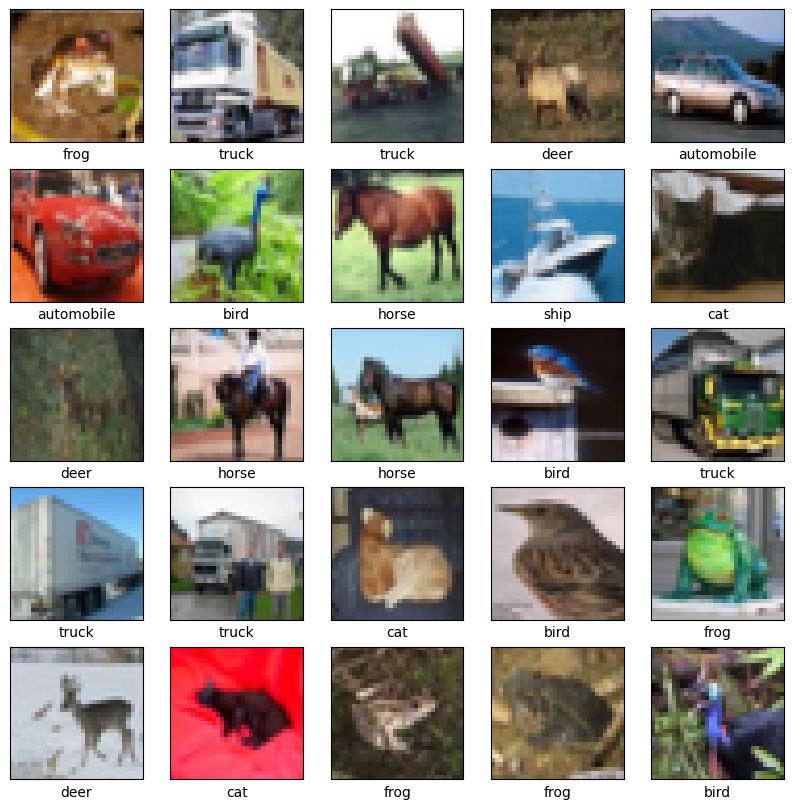

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

We can now create an `ImageDataGenerator` that can do data augmentation.

In [ ]:
data_generator = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2
)

In [ ]:
NUM_CLASSES = len(class_names)

y_train_value = train_labels.flatten().copy()
y_train = to_categorical(y_train_value, NUM_CLASSES)

Once we have a generator, we can `flow` from an array batches of data. Note that one can also `flow_from_dataframe` and `flow_from_directory` to avoid importing all the data into memory. This way data are collected in batches, augmented, used for training, and then cleared from memory.

In [ ]:
# Create an augmented image
batch_size = 1

batch_1 = data_generator.flow(train_images, y_train_value, batch_size = batch_size, shuffle=False)

In [ ]:
batch_1[0][0].shape # Image (shape = (batch_size, 32, 32, 3))

(1, 32, 32, 3)

In [ ]:
batch_1[0][1] # Label

array([6], dtype=uint8)

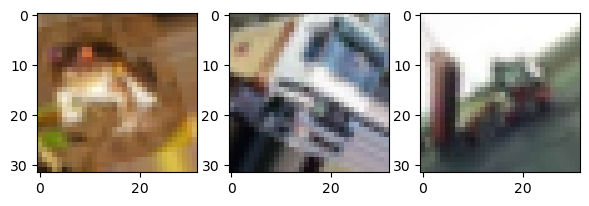

In [ ]:
plt.figure(figsize=(7,5))
for i in range(1,4):
    plt.subplot(1, 3, i)
    batch = batch_1.next()
    image_ = batch[0]
    image_ = image_.reshape(32,32,3)
    plt.imshow(image_)
plt.show()

# Training with data augmentation

We can now create generators for training and validation. Recall we want to augment training images, but not test images.

In [ ]:
data_generator = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.1,
)

In [ ]:
# Create an augmented image
batch_size = 1

batch_1 = data_generator.flow(train_images, y_train_value, batch_size = batch_size, shuffle=False)

In [ ]:
batch = batch_1.next()

In [ ]:
bat = batch[0].reshape(32,32,3)
bat.shape

(32, 32, 3)

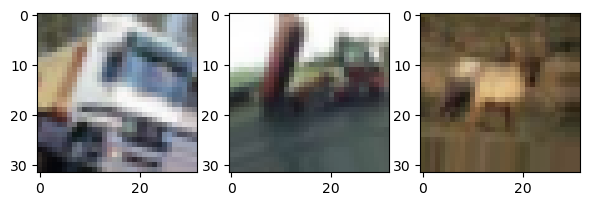

In [ ]:
plt.figure(figsize=(7,5))
for i in range(1,4):
    plt.subplot(1, 3, i)
    batch = batch_1.next()
    image_ = batch[0]
    image_ = image_.reshape(32,32,3)
    plt.imshow(image_)
plt.show()

In [ ]:
data_generator_validation = ImageDataGenerator()

In [ ]:
BATCH_SIZE = 64
EPOCHS = 10

In [ ]:
x_train = tf.cast(train_images, tf.float32)
x_test = tf.cast(test_images, tf.float32)

y_train_value = tf.cast(train_labels.flatten(), tf.int32)
y_test_value = tf.cast(test_labels.flatten(), tf.int32)

NUM_CLASSES = 10

y_train = to_categorical(y_train_value, NUM_CLASSES)
y_test = to_categorical(y_test_value, NUM_CLASSES)

In [ ]:
input_layer = layers.Input(shape = (32, 32, 3))

x = layers.Conv2D(filters = 32, kernel_size=(3,3), padding='same', activation = 'relu')(input_layer)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(filters = 64, kernel_size=(3,3), padding='same', activation = 'relu')(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(filters = 64, kernel_size=(3,3), padding='same', activation = 'relu')(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Flatten()(x)

x = layers.Dense(64, activation = 'relu')(x)

output_layer = layers.Dense(10, activation = 'softmax')(x)

model = Model(input_layer, output_layer)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [ ]:
train_data_flow = data_generator.flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_data_flow = data_generator_validation.flow(x_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

model.fit(train_data_flow, epochs = 10, validation_data = val_data_flow,
          steps_per_epoch = len(x_train) // BATCH_SIZE, validation_steps = len(x_test) // BATCH_SIZE,
          verbose = 1)

Epoch 1/10
781/781 [==============================] - 20s 20ms/step - loss: 1.7131 - acc: 0.3731 - val_loss: 261.6543 - val_acc: 0.3462
Epoch 2/10
781/781 [==============================] - 16s 20ms/step - loss: 1.4114 - acc: 0.4897 - val_loss: 274.0349 - val_acc: 0.3837
Epoch 3/10
781/781 [==============================] - 16s 20ms/step - loss: 1.2908 - acc: 0.5374 - val_loss: 214.0968 - val_acc: 0.4402
Epoch 4/10
781/781 [==============================] - 16s 20ms/step - loss: 1.2125 - acc: 0.5681 - val_loss: 240.8961 - val_acc: 0.4143
Epoch 5/10
781/781 [==============================] - 16s 20ms/step - loss: 1.1529 - acc: 0.5913 - val_loss: 267.3111 - val_acc: 0.4192
Epoch 6/10
781/781 [==============================] - 16s 20ms/step - loss: 1.1118 - acc: 0.6069 - val_loss: 188.0804 - val_acc: 0.4568
Epoch 7/10
781/781 [==============================] - 16s 20ms/step - loss: 1.0822 - acc: 0.6160 - val_loss: 226.5264 - val_acc: 0.4149
Epoch 8/10
781/781 [============================

## Get predictions

Note that in the test generator we set `shuffle=False`. This is crucial to avoid the test data of the features being shuffled and then not matching the indexes of the original `y_test`.

In [ ]:
probs_test = model.predict(val_data_flow)
preds_test = probs_test.argmax(axis=1)

In [ ]:
np.mean(preds_test == y_test_value)

0.4611

Note that one would have to train a much larger model, use regularisation, and apply data augmentation to improve the results. Given the compute limit on campus, we do not demonstrate how to get the best model, but merely demonstrate data augmentation. Please use `Google Colab` and select the GPU runtime (this is free). Then build a bigger model and train it for more epochs on this dataset.

# Pre-trained Models

Current image datasets are massive. For example, the ImageNet data set contains more than 1000 different classes and millions of images. These datasets cover a very wide range of objects expected to be seen by humans or models. Large models that achieve state-of-the art performances have been trained on these datasets. It is believed that the feature maps of these convolutions contain some information about general objects in images.

Given this assumption, one can use a pre-trained model (trained on ImageNet) to make predictions of images with similar categories to those of image net. Furthermore, one can use these out-of-the-box models' convolutional layers as feature extractors, and then train a very small neural network (usually linear) on a new, small dataset.

The motivation is that ConvNets require very large datasets. Using a pre-trained model, the weights of the convolutional layers are fixed (`trainable=False`), and we assume that some information from ImageNet and the pre-trained model is useful in predicting the new (possibly small) dataset. One therefore uses the pre-trained model to extract feature maps, and then train a very small model on-top of these layers. This is known as transfer learning, since we transfer knowledge from one model to the next.

Once transfer learning is complete, one may start to unfreeze some of the convolutional layers, starting with the ones deepest down the model. We unfreeze the weights of these layers sequentially, and further train the model to fine tune it. This is known as fine tuning a pre-trained model.

There are numerous pre-trained model for image recognition (as well as NLP). The most popular ones are:

 - ResNet
 - VGG
 - EfficientNet
 - MobileNet
 - DenseNet
 - Inception
 - Xception

We will now consider using a pre-trained model (this tutorial is adapted from [here](https://www.tensorflow.org/tutorials/images/transfer_learning)).

In [ ]:
import os

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


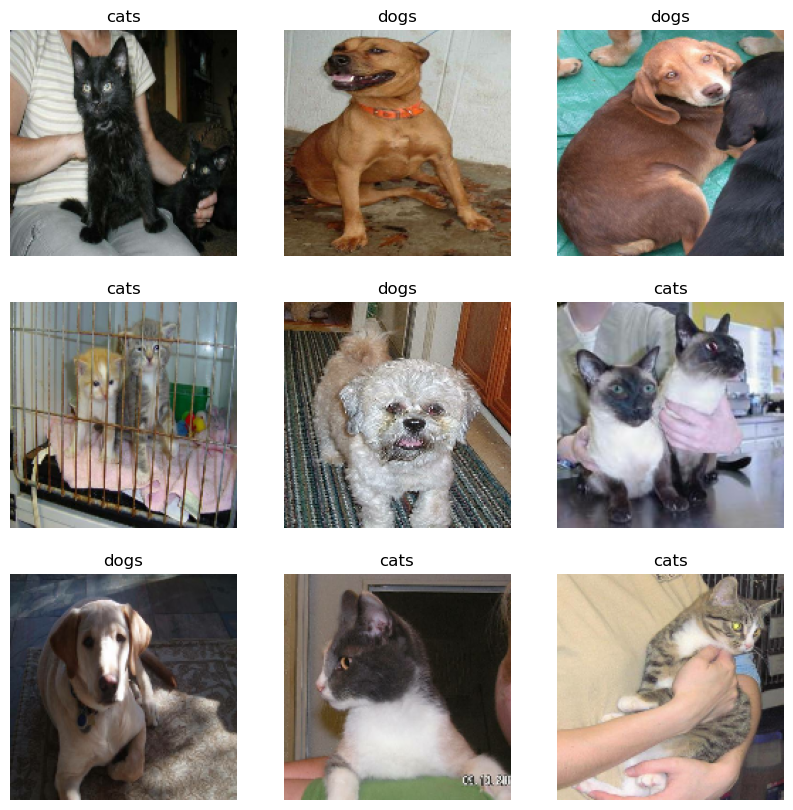

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

As the original dataset does not contain a test set. To create a test set, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
# Note this is for performance gains
# This performs buffered prefetching to load images from disk without having I/O become blocking
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## MobileNetV2

We will now load and use `MobileNetV2` for transfer learning.

In [ ]:
IMG_SIZE

(160, 160)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE

(160, 160, 3)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Note that each model has pre-processed image inputs in some way. For example, standardisation vs dividing by 255. Therefore, eachpre-trained model has a `preprocess_input` method that can either be applied in memory to loaded data, or supplied to an `ImageDataGenerator`.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

We can use layers for data augmentation.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

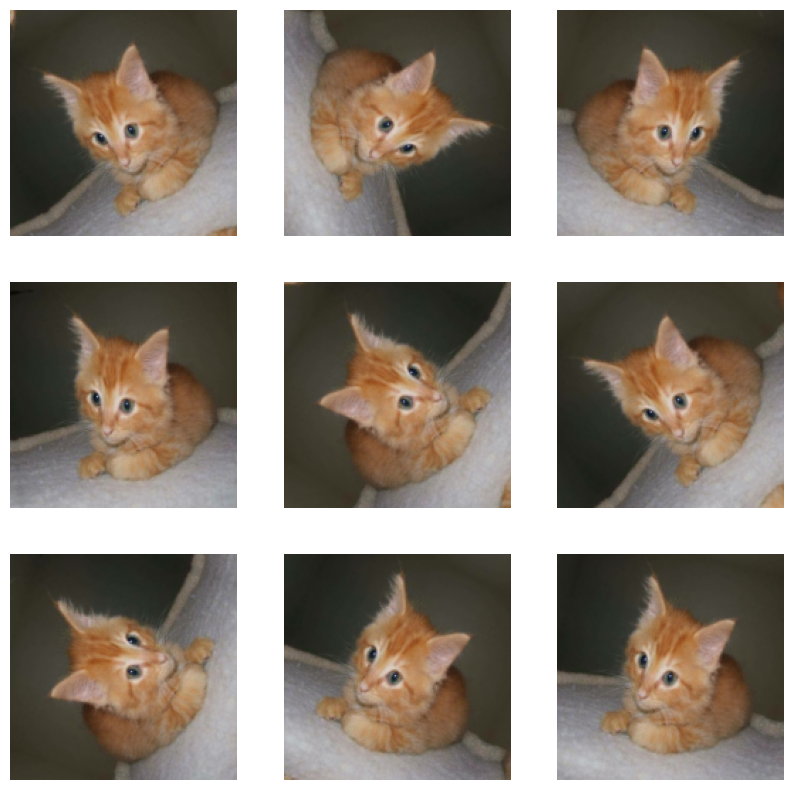

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Set all the convolutional layers of the base model to `trainable=False`.

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

As will be seen shortly, we must still set `training=False` when calling the base model. This ensure that the `BatchNormalization` layers are used correctly. Next, we add a classification head to the model.

In [ ]:
#train_images = np.concatenate([x for x, y in train_dataset], axis=0)
#train_labels = np.concatenate([y for x, y in train_dataset], axis=0)

#val_images = np.concatenate([x for x, y in validation_dataset], axis=0)
#val_labels = np.concatenate([y for x, y in validation_dataset], axis=0)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 2s 34ms/step - loss: 0.7240 - accuracy: 0.5309


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.72
initial accuracy: 0.53


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 4s 37ms/step - loss: 0.6784 - accuracy: 0.5995 - val_loss: 0.4937 - val_accuracy: 0.7847
Epoch 2/10
63/63 [==============================] - 2s 36ms/step - loss: 0.5143 - accuracy: 0.7605 - val_loss: 0.3671 - val_accuracy: 0.8911
Epoch 3/10
63/63 [==============================] - 2s 36ms/step - loss: 0.4059 - accuracy: 0.8290 - val_loss: 0.2828 - val_accuracy: 0.9270
Epoch 4/10
63/63 [==============================] - 2s 36ms/step - loss: 0.3497 - accuracy: 0.8685 - val_loss: 0.2335 - val_accuracy: 0.9468
Epoch 5/10
63/63 [==============================] - 2s 36ms/step - loss: 0.3107 - accuracy: 0.8915 - val_loss: 0.1984 - val_accuracy: 0.9554
Epoch 6/10
63/63 [==============================] - 2s 36ms/step - loss: 0.2634 - accuracy: 0.9050 - val_loss: 0.1764 - val_accuracy: 0.9616
Epoch 7/10
63/63 [==============================] - 2s 36ms/step - loss: 0.2469 - accuracy: 0.9135 - val_loss: 0.1570 - val_accuracy: 0.9641
Epoch 8/10
63

# Plot learning progress

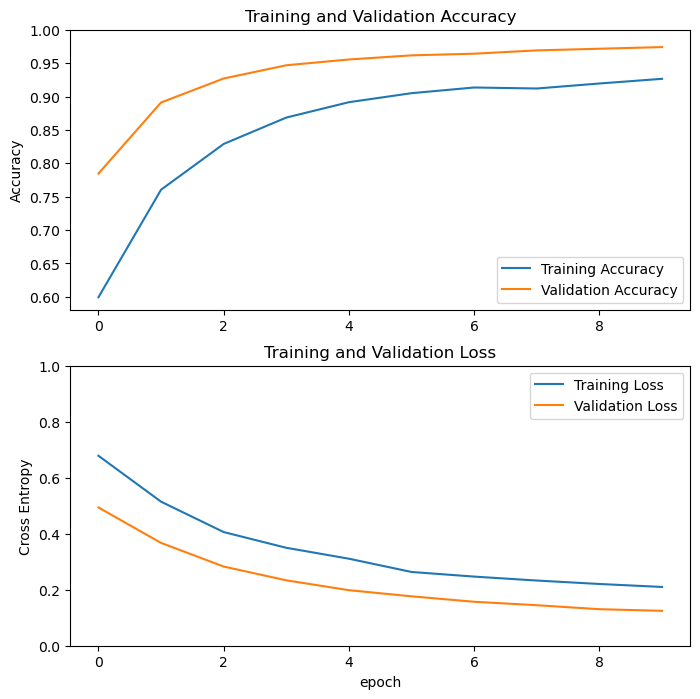

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

We will now set some of the convolutional blocks to `trainable=True`.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [ ]:
len(model.trainable_variables) # Number of unfreezed layers

56

In [ ]:
fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/13
63/63 [==============================] - 7s 64ms/step - loss: 0.1566 - accuracy: 0.9400 - val_loss: 0.0620 - val_accuracy: 0.9802
Epoch 11/13
63/63 [==============================] - 4s 55ms/step - loss: 0.1211 - accuracy: 0.9540 - val_loss: 0.0458 - val_accuracy: 0.9864
Epoch 12/13
63/63 [==============================] - 4s 55ms/step - loss: 0.1158 - accuracy: 0.9590 - val_loss: 0.0502 - val_accuracy: 0.9827
Epoch 13/13
63/63 [==============================] - 3s 54ms/step - loss: 0.0947 - accuracy: 0.9640 - val_loss: 0.0409 - val_accuracy: 0.9876


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

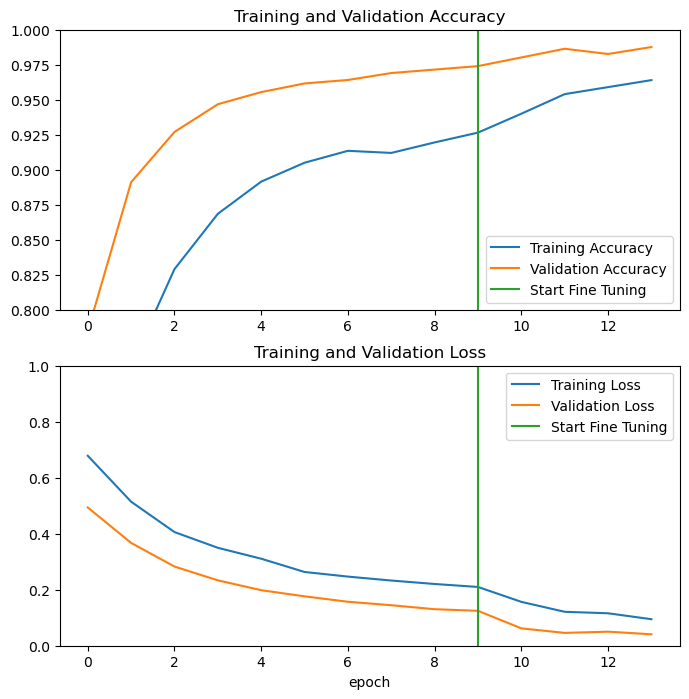

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 29ms/step - loss: 0.0407 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0]
Labels:
 [0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0]


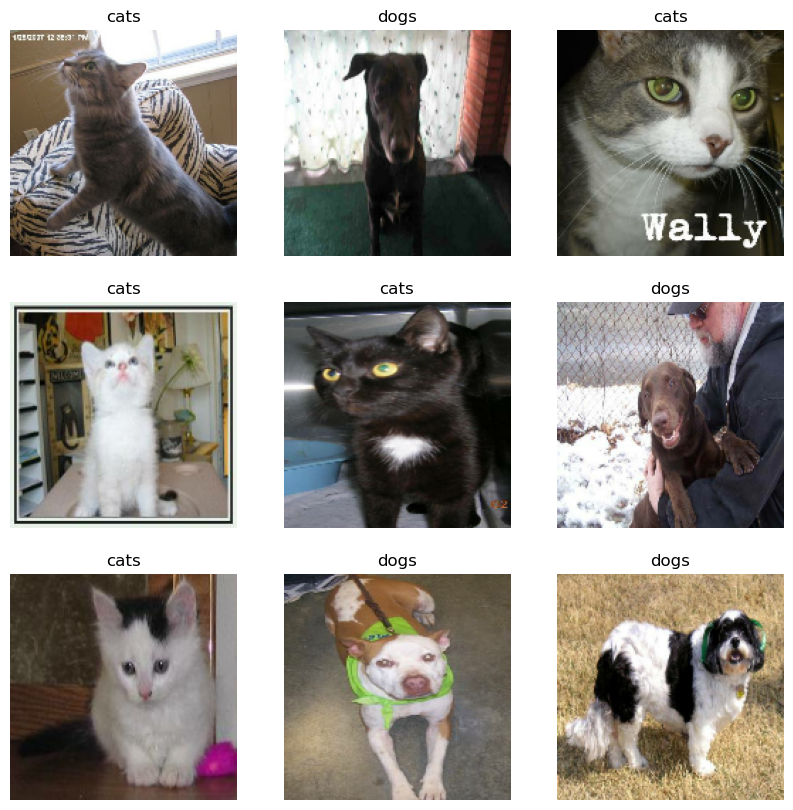

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")